In [0]:
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import itertools
from lightgbm import LGBMRegressor
from google.colab import drive

random.seed(42)
warnings.filterwarnings("ignore")

In [0]:
# Mount Google drive to fetch the dataset
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# load train and test data 
train_data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train_V2.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test_V2.csv')

NameError: ignored

In [1]:
# unique count of Id, groupId, matchId
for i in ['Id', 'groupId', 'matchId']:
  print(f'unique[{i}] count:', train_data[i].nunique()) 

NameError: ignored

In [0]:
# load train data
def reload():
    
    # run the garbage collector
    gc.collect()
    
    # read the input train data
    df = train_data
    
    # get matchIds for invalid (NaN) values of winPlacePerc (there exists 1 such row)
    invalid_match_ids = df[df['winPlacePerc'].isna()]['matchId'].values

    # remove the invalid matchIds from train dataset and use the updated df
    df = df[-df['matchId'].isin(invalid_match_ids)]
    
    return df


pearson correlation betweeen the features and the target

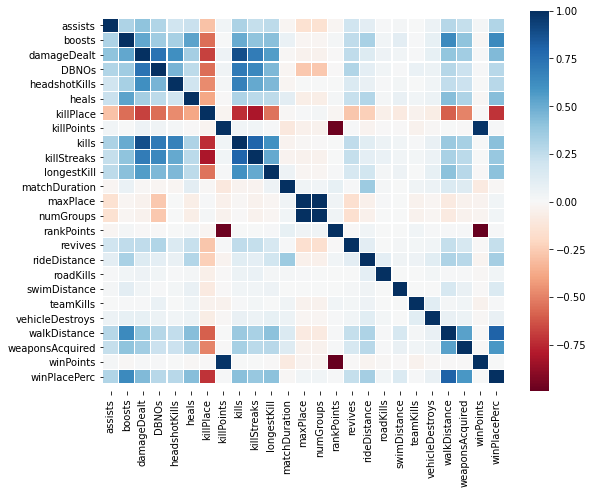

In [0]:
# get the train data without NaN for target values
df = reload()

# list the features to drop
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']

# get the required features to fit
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]

# get the pearson correlation
corr = df[cols_to_fit].corr()

# plot the correlation
plt.figure(figsize=(9,7))
ax = sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

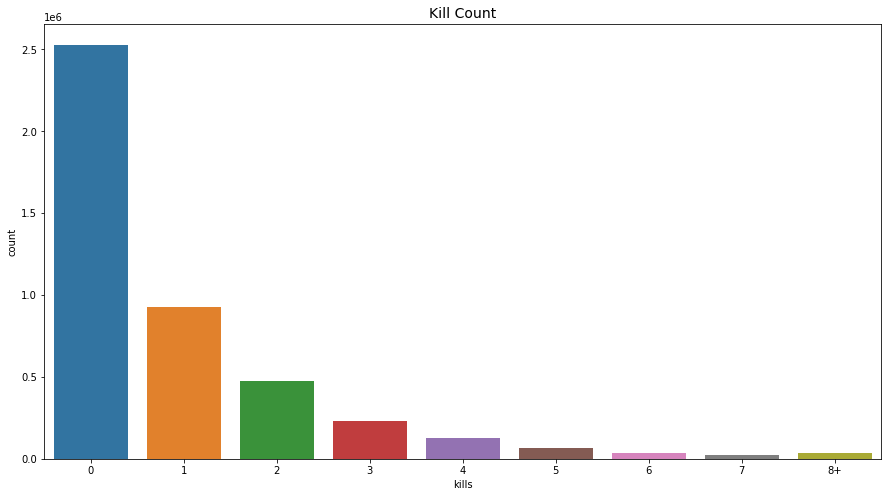

In [0]:
# plot distribution of number of kills by players
data = train_data.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15, 8))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title('Kill Count', fontsize=14)
plt.show()

# most of the people cannot make a single kill

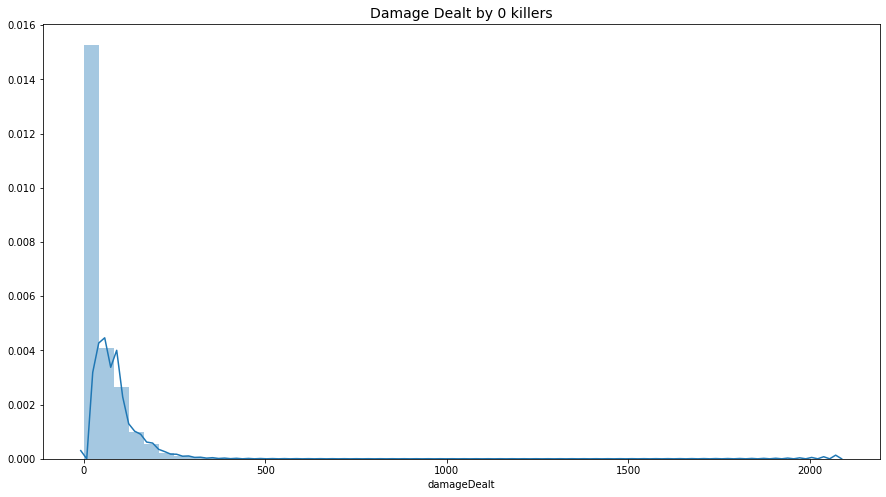

In [0]:
# find damage done by players who has 0 kills
data = train_data.copy()
data = data[data['kills'] == 0]
plt.figure(figsize=(15, 8))
plt.title('Damage Dealt by 0 killers', fontsize=14)
sns.distplot(data['damageDealt'])
plt.show() 

In [0]:
# find players who won the game without/less than a single kill
print("{} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train_data)))

data1 = train_data[train_data['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train_data)))

16666 players (0.3748%) have won without a single kill!
4770 players (0.1073%) have won without dealing damage!


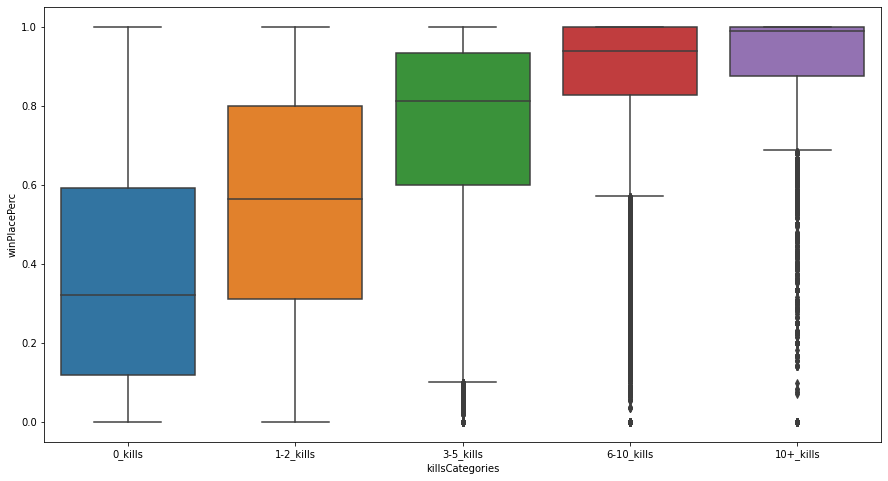

In [0]:
# find effect of killing on winning %
kills = train_data.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

pearson correlation between selected and new features

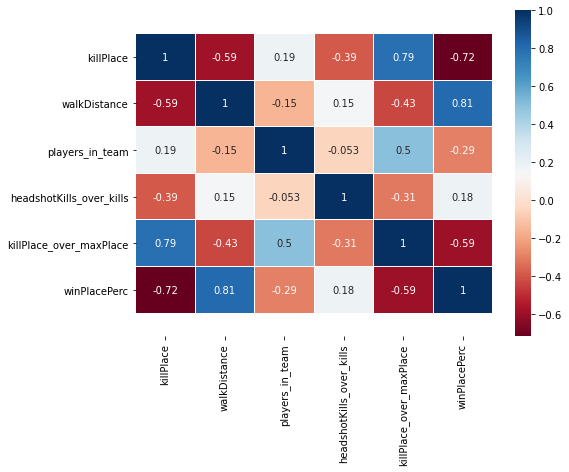

In [0]:
# new feature creation
agg = df.groupby(['groupId']).size().to_frame('players_in_team')
df = df.merge(agg, how='left', on=['groupId'])
df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
df['headshotKills_over_kills'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
df['killPlace_over_maxPlace'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
corr = df[['killPlace', 'walkDistance', 'players_in_team', 'headshotKills_over_kills', 'killPlace_over_maxPlace', 'winPlacePerc']].corr()

plt.figure(figsize=(8,6))
ax = sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()


Linear Regression Model

In [0]:
# split train dataset into train (90%) and test(10%) based on matchId
def train_test_split(df, test_size = 0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids, train_size)
    
    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train, test

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def run_experiment(preprocess):
    df = reload()
    df.drop(columns = ['matchType'], inplace = True)
    
    df = preprocess(df)
    
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target]
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    
    train, test = train_test_split(df, 0.1)
    
    model = LinearRegression()
    model.fit(train[cols_to_fit], train[target])
    
    y_true = test[target]
    y_predict = model.predict(test[cols_to_fit])
    
    return mean_absolute_error(y_true, y_predict)

# driver method for run_experiment method
def driver(preprocesses):
    results = []
    for preprocess in preprocesses:
        start = time.time()
        score = run_experiment(preprocess)
        end_time = time.time() - start
        results.append({
            'name': preprocess.__name__,
            'score': score,
            'execution time': f'{round(end_time, 2)}s'
        })
        gc.collect()
    return pd.DataFrame(results, columns=['name', 'score', 'execution time']).sort_values(by='score')

In [0]:
def original(df):
    return df

# create new features  
def items(df):
    df['items'] = df['heals'] + df['boosts']
    return df

def players_in_team(df):
    agg = df.groupby(['groupId']).size().to_frame('players_in_team')
    return df.merge(agg, how='left', on=['groupId'])

def total_distance(df):
    df['total_distance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
    return df

def headshotKills_over_kills(df):
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['headshotKills_over_kills'].fillna(0, inplace=True)
    df['headshotKills_over_kills'].replace(np.inf, 0, inplace=True)
    return df

def killPlace_over_maxPlace(df):
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['killPlace_over_maxPlace'].fillna(0, inplace=True)
    df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_heals(df):
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'].fillna(0, inplace=True)
    df['walkDistance_over_heals'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_kills(df):
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['walkDistance_over_kills'].fillna(0, inplace=True)
    df['walkDistance_over_kills'].replace(np.inf, 0, inplace=True)
    return df

def teamwork(df):
    df['teamwork'] = df['assists'] + df['revives']
    return df

driver([
    original,
    items,
    players_in_team,
    total_distance,
    headshotKills_over_kills,
    killPlace_over_maxPlace,
    walkDistance_over_heals,
    walkDistance_over_kills,
    teamwork
])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/py

,name,score,execution time
4,headshotKills_over_kills,0.091597,8.08s
2,players_in_team,0.091758,22.14s
5,killPlace_over_maxPlace,0.091949,8.08s
7,walkDistance_over_kills,0.092258,8.13s
6,walkDistance_over_heals,0.092284,8.2s
0,original,0.092412,9.02s
1,items,0.092493,8.63s
8,teamwork,0.092811,8.47s
3,total_distance,0.092969,8.16s


In [0]:
def min_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['', '_min'], how='left', on=['matchId', 'groupId'])

def max_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].max()
    return df.merge(agg, suffixes=['', '_max'], how='left', on=['matchId', 'groupId'])

def sum_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].sum()
    return df.merge(agg, suffixes=['', '_sum'], how='left', on=['matchId', 'groupId'])

def median_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].median()
    return df.merge(agg, suffixes=['', '_median'], how='left', on=['matchId', 'groupId'])

def mean_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    return df.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

def rank_by_team(df):
    cols_to_drop = ['Id', 'groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId', 'groupId'])[features].mean()
    agg = agg.groupby('matchId')[features].rank(pct=True)
    return df.merge(agg, suffixes=['', '_mean_rank'], how='left', on=['matchId', 'groupId'])

driver([
    original,
    min_by_team,
    max_by_team,
    sum_by_team,
    median_by_team,
    mean_by_team,
    rank_by_team
])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.p

,name,score,execution time
6,rank_by_team,0.057723,58.55s
4,median_by_team,0.076096,50.37s
5,mean_by_team,0.077007,47.57s
2,max_by_team,0.079271,51.07s
3,sum_by_team,0.087832,52.7s
1,min_by_team,0.089905,49.48s
0,original,0.092175,8.47s


Tree Model using Light GBM 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[20]	valid_0's l1: 0.0648862
[40]	valid_0's l1: 0.0617668
[60]	valid_0's l1: 0.0605104
[80]	valid_0's l1: 0.0599227
[100]	valid_0's l1: 0.0595812


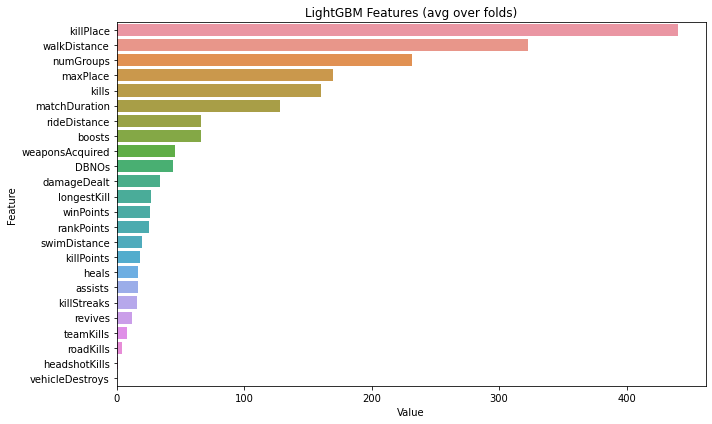

In [0]:
df = reload()

df.drop(columns=['matchType'], inplace=True)

target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
train, val = train_test_split(df, 0.1)


params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 20,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}

model = LGBMRegressor(**params)
model.fit(
    train[cols_to_fit], train[target],
    eval_set=[(val[cols_to_fit], val[target])],
    eval_metric='mae',
    verbose=20,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
